# Frozen Lake

### Описание задачи

**Характеристики игры**  
* Эпизодическая среда
* Стохастическая / Детерминированная среда
* Дискретная среда
* Среда с полной информацией

**Цель игры**  
Необходимо перейти из начального состояния **S** в целевое состояние **G**,<br> пройдя только по льду **F** и избегая полыньи **H**.<br>
Однако лед скользкий, поэтому вы не всегда будете двигаться в нужном направлении.

**Окружение**

<img src="http://simoninithomas.com/drlc/Qlearning/frozenlake4x4.png" />

**Пространство действий**

* Пойти направо
* Пойти налево
* Пойти вверх
* Пойти вниз

**Терминальные состояния**  
Эпизод заканчивается, когда вы достигаете цели или попадаете в полынью.

**Функция вознаграждения**  
Вы получаете вознаграждение в размере 1, если вы достигнете цели, и ноль в противном случае.

**Полезные ссылки**
* https://gymnasium.farama.org/environments/toy_text/frozen_lake
* https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto




***

### Установка зависимостей, импорт библиотек

In [2]:
import os
import sys
import PIL
import time
import json
import random
import numpy as np
import pandas as pd
import shutil as sh
from glob import glob
from datetime import datetime
from collections import deque, defaultdict
from base64 import b64encode
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
import seaborn as sns
import gymnasium as gym

### Определение путей и директорий

In [3]:
env_dir = './Frozen Lake'
scenarios_dir = os.path.join(env_dir, 'scenarios')

In [4]:
if not os.path.exists(scenarios_dir):
    os.makedirs(scenarios_dir)

### Вспомогательные методы

**Отображение состояния среды, сохранение записи эпизода, просмотр записи эпизода**

In [5]:
def display_state(state):
    plt.figure(figsize=(6, 6))
    plt.imshow(state)
    plt.axis('off')


def record_episode(eps_frames, records_dir, agent_name, exp_id, eps_num):
    record_path = os.path.join(records_dir, f'{agent_name}_{exp_id}_eps-{eps_num}.mp4')
    eps_frame_dir = 'episode_frames'
    os.mkdir(eps_frame_dir)

    for i, frame  in enumerate(eps_frames):
        PIL.Image.fromarray(frame).save(os.path.join(eps_frame_dir, f'frame-{i+1}.png'))

    os.system(f'ffmpeg -r 2 -i {eps_frame_dir}/frame-%1d.png -vcodec libx264 -b 10M -y "{record_path}"');
    sh.rmtree(eps_frame_dir)


def show_episode_records(records_dir):
    record_paths = glob(os.path.join(records_dir, "*.mp4"))
    html_str = ''
    for i, record_path in enumerate(record_paths):
        mp4 = open(record_path, 'rb').read()
        data = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        html_str += f'EPISODE # {i+1}<br><video width=500 controls><source src="{data}" type="video/mp4"></video><br><br>'
    return HTML(html_str)


**Создание директорий для логирования результатов, сохрание параметров и метрик экспериментов**

In [6]:
def create_exp_dirs(scenarios_dir, exp_params):
    dirs = dict()
    dirs['exp'] = os.path.join(scenarios_dir, exp_params["scenario_name"], exp_params["algorithm_name"], exp_params["exp_id"])
    dirs['training'] = os.path.join(dirs['exp'], 'training')
    dirs['evaluation'] = os.path.join(dirs['exp'], 'evaluation')
    os.makedirs(dirs['training'], exist_ok=True)
    os.makedirs(dirs['evaluation'], exist_ok=True)
    return dirs


def save_exp_params(params, exp_dir):
    params_path = os.path.join(exp_dir, 'experiment_params.json')
    with open(params_path, 'w') as f:
        json.dump(params, f)


def save_metrics(metrics, metrics_type, train_eps_dir):
    metrics_path = os.path.join(train_eps_dir, f'{metrics_type}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

**Построение графика процесса валидации для выбранных экспериментов**

In [7]:
def display_validation_plot(scenarios_dir, scenario_name, exp_ids):
    fig = plt.figure(figsize=(10, 6))
    earliest_validation_eps = np.inf
    max_training_eps_count = 0

    for model_name in exp_ids.keys():
        for exp_id in exp_ids[model_name]:
            exp_dir = os.path.join(scenarios_dir, scenario_name, model_name, exp_id)
            exp_params_path = os.path.join(exp_dir, 'experiment_params.json')
            training_dir = os.path.join(exp_dir, 'training')

            with open(exp_params_path, 'r') as f:
                exp_params = json.load(f)
            total_eps_count = exp_params['training']['episode_count']
            validation_step = exp_params['validation']['validate_agent_every_n_eps']
            if total_eps_count > max_training_eps_count:
                max_training_eps_count = total_eps_count
            if validation_step < earliest_validation_eps:
                earliest_validation_eps = validation_step

            exp_win_shares = list()
            for iter_name in os.listdir(training_dir):
                iter_metrics_path = os.path.join(training_dir, iter_name, 'training_iter_metrics.json')
                with open(iter_metrics_path, 'r') as f:
                    iter_metrics = json.load(f)
                exp_win_shares.append(iter_metrics['win_share'])

            iter_means = np.mean(exp_win_shares, axis=0).round(3)
            iter_stds = np.std(exp_win_shares, axis=0).round(3)
            std_bounds = np.array([[avg - std, avg + std] for avg, std in list(zip(iter_means, iter_stds))])
            validation_steps = range(validation_step, total_eps_count + validation_step, validation_step)

            plt.plot(validation_steps, iter_means, label=f'{model_name} ({exp_id})')
            plt.fill_between(validation_steps, std_bounds[:,0], std_bounds[:,1], alpha=.3)

    plt.xlim(earliest_validation_eps, max_training_eps_count)
    plt.ylim(0, 1)
    plt.xlabel('Training episodes')
    plt.ylabel('Win share')
    plt.title(f'Сomparative assessment of learning process ({scenario_name})')
    plt.legend(loc='upper left')
    plt.grid()

**Загрузка лучшего агента из всех итераций для выбранного шага обучения**

In [8]:
def load_best_agent_for_train_step(train_eps_num, iteration_count, training_dir, agent):
    best_iter_num = 1
    best_win_share = 0
    best_avg_step_count = 100
    for iter_num in range(1, iteration_count+1):
        iter_dir = os.path.join(training_dir, f'iter-{iter_num}')
        eps_dir = os.path.join(iter_dir, f'eps-{train_eps_num}')
        val_metrics_path = os.path.join(eps_dir, 'validation_metrics.json')
        with open(val_metrics_path, 'r') as f:
            val_metrics = json.load(f)
        if val_metrics['win_share'] > best_win_share and val_metrics['avg_step_count'] < best_avg_step_count:
            best_iter_num = iter_num
            best_win_share = val_metrics['win_share']
            best_avg_step_count = val_metrics['avg_step_count']

    agent_state_dir = os.path.join(training_dir, f'iter-{best_iter_num}', f'eps-{train_eps_num}')
    agent.load_agent_state(agent_state_dir)

### Методы для тренировки и валидации агента

In [9]:
def train_agent(env, agent, exp_params, exp_dirs, enable_eps_recording):
    random.seed(exp_params['seed'])
    np.random.seed(exp_params['seed'])

    train_iter_count = len(os.listdir(exp_dirs['training']))
    train_iter_dir = os.path.join(exp_dirs['training'], f'iter-{train_iter_count+1}')
    os.mkdir(train_iter_dir)

    training_eps_count = exp_params['training']['episode_count']
    validate_agent_every_n_eps = exp_params['validation']['validate_agent_every_n_eps']
    validation_eps_count = exp_params['validation']['episode_count']

    train_metrics = {
        'total_eps_count': training_eps_count,
        'validation_step': validate_agent_every_n_eps,
        'win_share': []
    }

    for eps_num in range(1, training_eps_count + 1):
        state, info = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state, mode='exploration')
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.learn(state, action, next_state, reward)
            done = terminated or truncated
            state = next_state

        agent.decrease_exploration_level()

        if eps_num % validate_agent_every_n_eps == 0:
            eps_dir = os.path.join(train_iter_dir, f'eps-{eps_num}')
            os.mkdir(eps_dir)

            val_metrics = validate_agent(env, agent, exp_params, eps_dir, enable_eps_recording)
            train_metrics['win_share'].append(val_metrics['win_share'])
            agent.save_q_table_as_plot(eps_dir)
            agent.save_agent_state(eps_dir)

            print(f"EPISODE # {eps_num} / {training_eps_count}")
            print(f"Win share ({validation_eps_count} eps): {val_metrics['win_share']}")
            print(f"Avg step count ({validation_eps_count} eps): {val_metrics['avg_step_count']}")
            print(f"Aget exploration level (epsilon): {val_metrics['exploration_level']}")
            print('-' * 50)

    save_metrics(train_metrics, 'training_iter', train_iter_dir)
    return train_metrics


def validate_agent(env, agent, exp_params, train_eps_dir, enable_eps_recording):
    validation_eps_count = exp_params['validation']['episode_count']
    won_eps_count = 0
    eps_step_counts = list()

    for eps_num in range(1, validation_eps_count + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        if eps_final_state == env.observation_space.n - 1:
            won_eps_count += 1
        eps_step_counts.append(eps_step_count)
        if enable_eps_recording:
            record_episode(eps_frames, train_eps_dir, exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

    val_metrics = {
        'win_share': round(won_eps_count / validation_eps_count, 3),
        'avg_step_count': round(sum(eps_step_counts) / validation_eps_count, 3),
        'exploration_level': round(agent.exploration_level, 3)
    }

    save_metrics(val_metrics, 'validation', train_eps_dir)
    return val_metrics

### Параметры эксперимента

In [10]:
MAP_SIZE = 8
STOCHASTIC_ENV = False
ACTION_MAP = {
    'L': 0,
    'D': 1,
    'R': 2,
    'U': 3
}

### Реализация агента

In [11]:
class DynaQAgent:

    def __init__(self, env, env_model_cls, params):
        self._env = env
        self._params = params
        self._epsilon = params['training']['epsilon']
        self._qtable = np.zeros((env.observation_space.n, env.action_space.n))
        self._model = env_model_cls(env.observation_space.n, env.action_space.n)
        self._action_arrow_map = { 0: '', 1: '←', 2: '↓', 3: '→', 4: '↑' }

    @property
    def name(self):
        return f"{self._params['algorithm_name']}_agent"

    @property
    def exploration_level(self):
        return self._epsilon


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
          if np.random.rand() < self._epsilon:
              return self._env.action_space.sample()

        return np.argmax(self._qtable[state, :])


    def learn(self, state, action, next_state, reward):
        self._learn(state, action, next_state, reward)
        self._update_model(state, action, next_state, reward)
        self._planning(self._params['training']['planning_steps'])


    def decrease_exploration_level(self):
        if self._epsilon > self._params['training']['epsilon_min']:
            self._epsilon *= self._params['training']['epsilon_decay_rate']


    def display_q_table(self):
        self._prepare_q_table()


    def save_q_table_as_plot(self, eps_dir):
        q_table_plot = self._prepare_q_table()
        q_table_plot_path = os.path.join(eps_dir, 'qtable.png')
        q_table_plot.savefig(q_table_plot_path, bbox_inches='tight')
        plt.close(q_table_plot)


    def display_model(self):
        print(f'Transitions tabel:\n')
        self._model.display_transitions()
        print(f'\n\nRewards tabel:\n')
        self._model.display_rewards()


    def save_agent_state(self, state_dir):
        np.save(os.path.join(state_dir, 'qtable.npy'), self._qtable)
        np.save(os.path.join(state_dir, 'model_transitions.npy'), self._model.transitions)
        np.save(os.path.join(state_dir, 'model_rewards.npy'), self._model.rewards)


    def load_agent_state(self, state_dir):
        self._qtable = np.load(os.path.join(state_dir, 'qtable.npy'), allow_pickle=True)
        self._model.transitions = np.load(os.path.join(state_dir, 'model_transitions.npy'), allow_pickle=True)
        self._model.rewards = np.load(os.path.join(state_dir, 'model_rewards.npy'), allow_pickle=True)


    def _learn(self, state, action, next_state, reward):
        target = reward + self._params['training']['gamma'] * np.max(self._qtable[next_state, :])
        self._qtable[state, action] = self._qtable[state, action] + \
                                      self._params['training']['learning_rate'] * (target - self._qtable[state, action])


    def _update_model(self, state, action, next_state, reward):
        self._model.update(state, action, next_state, reward)


    def _planning(self, n_steps):
        for i in range(n_steps):
            state, action =  self._model.sample()
            next_state, reward = self._model.step(state, action)
            self._learn(state, action, next_state, reward)


    def _prepare_q_table(self):
        greedy_values = np.max(self._qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
        greedy_actions = np.argmax(np.hstack((np.zeros((self._env.observation_space.n, 1)), self._qtable)), axis=1)
        greedy_actions_arrows = np.array(list(map(lambda x: '' if x == 0 else self._action_arrow_map[x], greedy_actions))).reshape(MAP_SIZE, MAP_SIZE)

        fig = plt.figure()
        sns.heatmap(greedy_values,
                    annot=greedy_actions_arrows,
                    annot_kws={"fontsize": 16},
                    fmt = '',
                    cmap="YlGnBu",
                    linewidths=.5)
        plt.axis('off')
        return fig


### Тестирование Q-агента в стохастической среде

In [12]:
def create_environment(map_size, stochastic_env):
    return gym.make('FrozenLake-v1', map_name=f'{map_size}x{map_size}', is_slippery=stochastic_env, render_mode='rgb_array')

In [13]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'dynaq',
    'exp_id': f'exp-{datetime.now().strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 5,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995,
        'planning_steps': 30
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 5
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [14]:
def run_episode(env, agent):
    state, info = env.reset()
    step_count = 0
    frames = list()
    done = False

    while not done:
        action = agent.choose_action(state, mode='exploitation')
        next_state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        done = terminated or truncated
        state = next_state
        step_count += 1

    frames.extend([env.render()] * 3)
    return state, step_count, frames


def evaluate_agent(env, agent, exp_params, exp_dirs):
    for eps_num in range(1, exp_params['evaluation']['episode_count'] + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        record_episode(eps_frames, exp_dirs['evaluation'], exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

        print(f'EPISODE # {eps_num}')
        if eps_final_state == env.observation_space.n - 1:
            print('Agent reached the Goal 🏆')
        else:
            print('Agent was defeated ☠️')
        print(f'Number of steps: {eps_step_count}')
        print('-' * 50)

### Реализация модели окружения (Домашнее задание!)

Необходимо реализовать класс *StochasticEnvModel* для моделирования стохастической версии окружения, за основу можно взять класс *DeterministicEnvModel*.

In [ ]:
class StochasticEnvModel:
    
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        # Словарь для хранения вероятностей и наград для каждой пары (состояние, действие)
        self.transition_probs = defaultdict(lambda: defaultdict(dict))  
        self.reward_table = defaultdict(lambda: defaultdict(float))
        self.transitions = np.zeros((n_states, n_actions), dtype=np.uint8)
        self.rewards = np.zeros((n_states, n_actions), dtype=np.uint8)
        # Набор завершенных переходов
        self.completed_transitions = set()

    def update(self, state, action, next_state, reward, prob=1.0):
        key = (state, action)
        if key not in self.completed_transitions:
            self.completed_transitions.add(key)
        # Добавляем новый возможный переход
        self.transition_probs[key][next_state] = prob
        self.reward_table[key][next_state] += reward * prob

    def sample(self):
        return random.choice(list(self.completed_transitions))

    def step(self, state, action):
        possible_next_states = list(self.transition_probs[(state, action)].keys())
        probs = list(self.transition_probs[(state, action)].values())
        probs = [prob / sum(probs) for prob in probs]
        # Выбор следующего состояния с учетом вероятностей
        next_state = np.random.choice(possible_next_states, p=probs)
        reward = self.reward_table[(state, action)][next_state]
        return next_state, reward

    def display_transitions(self):
        display(HTML(pd.DataFrame(self.transitions, columns=['L', 'D', 'R', 'U']).T.to_html()))

    def display_rewards(self):
        display(HTML(pd.DataFrame(self.rewards, columns=['L', 'D', 'R', 'U']).T.to_html()))


### Обучение агента

In [ ]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    dynaq_agent = DynaQAgent(env, StochasticEnvModel, exp_params)
    train_agent(env, dynaq_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

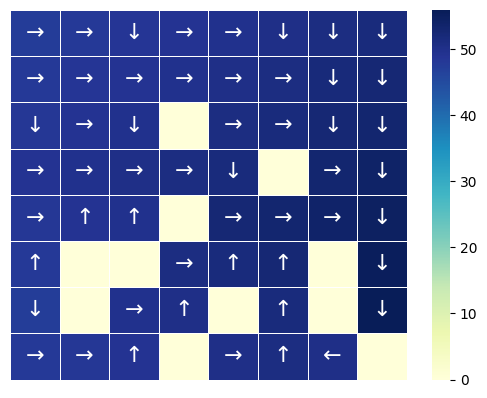

In [24]:
dynaq_agent.display_q_table()

In [25]:
dynaq_agent.display_model()

Transitions tabel:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
U,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




Rewards tabel:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
U,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Оценка агента

In [26]:
train_eps_num = 4000

load_best_agent_for_train_step(train_eps_num,
                               exp_params['training']['iteration_count'],
                               exp_dirs['training'],
                               dynaq_agent)

In [ ]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, dynaq_agent, exp_params, exp_dirs)
env.close()

In [ ]:
show_episode_records(exp_dirs['evaluation'])